In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
import os
import itertools as it
import shutil

import sqlite3
import numpy as np
import matplotlib.pyplot as plt

import kelp_compute
import kelp_analyze
import discrete_plot
import error_visualize

# Compare Asymptotics to FD

In [26]:
def cori_asymptotics_study_plot_one_iop_set(study_name, a_water, b):
    """
    Make two plots:
    - perceived irradiance vs. depth for FD and all asymptotics
    - error vs. number of scatters
    """
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)
    
    # Get run data from .nc files
    run_list = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b)
    # Assume that there's only one FD run for each IOP set
    fd_run_ds = [run for run in run_list if run['fd_flag'][:] == True][0]
    fd_perceived_irrad = kelp_analyze.calculate_perceived_irrad(
        fd_run_ds['p_kelp'][:],
        fd_run_ds['irrad'][:]
    )
    
    asymptotics_run_dict = {
        int(run_ds['num_scatters'][:]): run_ds
        for run_ds in run_list
        if run_ds['fd_flag'][:] != True
    }
    
    nz = fd_run_ds['nz'][:]
    zmin = 0
    zmax = fd_run_ds['zmax'][:]
    dz = (zmax-zmin)/nz
    z = dz * (np.arange(nz) + 0.5)
    
    plt.figure(1, figsize=[10,8])
    plt.plot(z, fd_perceived_irrad, 'o-', label='FD')
    
    num_scatters_list = sorted(asymptotics_run_dict.keys())
    for num_scatters in reversed(num_scatters_list):
        run_ds = asymptotics_run_dict[num_scatters]
        perceived_irrad = kelp_analyze.calculate_perceived_irrad(
            run_ds['p_kelp'][:], 
            run_ds['irrad'][:]
        )
        
        plt.plot(z, perceived_irrad, 'o-', label='n={}'.format(num_scatters))
        
        # TODO: Calculate error & save to list
        
    plt.figure(1)
    plt.legend()
        
    # TODO: Plot error
    # plt.figure(2)

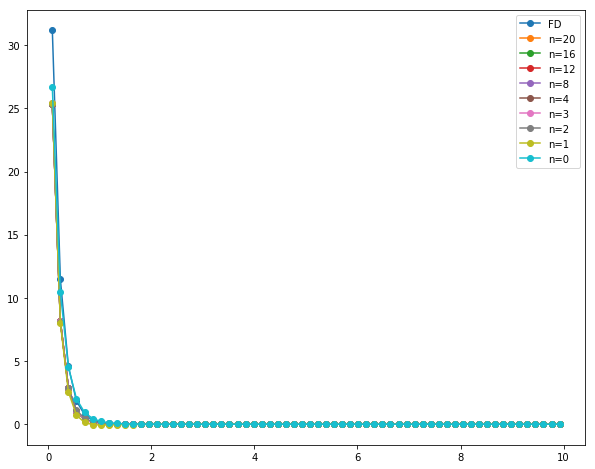

In [27]:
study_name = 'as_n64_9ax9b'
#plt.yscale('log')
a_water = 0.0
b = 1.6
cori_asymptotics_study_plot_one_iop_set(study_name, a_water, b)

# Compare errors from 1e-5 FD and 1e-12 FD

In [80]:
def cori_compare_two_fd(study_name_list, a_water, b):
    z_list = []
    perceived_irrad_list = []
    for study_name in study_name_list:
        # Connect
        base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
        study_dir = os.path.join(base_dir, study_name)
        db_path = os.path.join(study_dir, '{}.db'.format(study_name))
        conn = sqlite3.connect(db_path)
    
        # Get run data from .nc files
        run_list = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b)
        conn.close()
        
        # Assume that there's only one FD run for each IOP set
        fd_run_ds = [run for run in run_list if run['fd_flag'][:] == True][0]
        fd_perceived_irrad = kelp_analyze.calculate_perceived_irrad(
            fd_run_ds['p_kelp'][:],
            fd_run_ds['irrad'][:]
        )

        nz = fd_run_ds['nz'][:]
        zmin = 0
        zmax = fd_run_ds['zmax'][:]
        dz = (zmax-zmin)/nz
        z = dz * (np.arange(nz) + 0.5)
        
        z_list.append(z)
        perceived_irrad_list.append(fd_perceived_irrad)
    
    return z_list, perceived_irrad_list
    

In [81]:
z_list, perceived_irrad_list = cori_compare_two_fd(
    ['as_single_tol5', 'as_single_tol12'],
    a_water=0.5,
    b=0.5
)

z, _ = z_list
pi5, pi12 = perceived_irrad_list

abs_diff:
mean = 1.168e-06
std = 7.333e-07
min = 4.147e-08
max = 2.661e-06

rel_diff:
mean = 3.588e-02
std = 6.025e-02
min = 8.432e-09
max = 2.424e-01


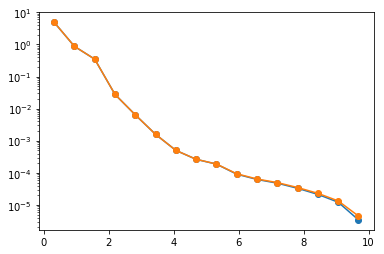

In [89]:
plt.plot(z, pi5, 'o-')
plt.plot(z, pi12, 'o-')
plt.yscale('log')

abs_diff = np.abs(pi5-pi12)
rel_diff = np.abs(abs_diff/pi12)
print("abs_diff:")
print("mean = {:.3e}".format(np.mean(abs_diff)))
print("std = {:.3e}".format(np.std(abs_diff)))
print("min = {:.3e}".format(np.min(abs_diff)))
print("max = {:.3e}".format(np.max(abs_diff)))
print()

print("rel_diff:")
print("mean = {:.3e}".format(np.mean(rel_diff)))
print("std = {:.3e}".format(np.std(rel_diff)))
print("min = {:.3e}".format(np.min(rel_diff)))
print("max = {:.3e}".format(np.max(rel_diff)))

Clearly, `tol=1e-5` is sufficient.

# Compare FD & asymptotics radiances to BC

In [115]:
def cori_nc_get_results(study_name, *quantity_names, **conditions):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)

    # Get run data from .nc files
    results_list = kelp_analyze.query_results(conn, study_name, **conditions)
    conn.close()
    
    return [
        [
            results[quantity_name][:] 
            for quantity_name in quantity_names
        ]
        for results in results_list
    ]


# Compare asymptotics to FD, fixed num_scatters

In [67]:
def analyze_asymptotics_study(study_name, num_scatters):
    # Open db
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)
    
    # Get a, b values
    cursor = conn.execute('''
    SELECT a_water, b, num_scatters
    FROM {study_name}
    '''.format(study_name=study_name))

    # Get all unique values of a_water, b
    types = (float, float, int)
    a_water_list, b_list, num_scatters_list = [
        sorted(
            set(
                map(
                    t,
                    col
                )
            )
        )
        for col, t in zip(
            zip(*cursor.fetchall()), 
            types
        )
    ]

    
    print("a_water_list = {}".format(a_water_list))
    print("b_list = {}".format(b_list))
    print("num_scatters_list = {}".format(num_scatters_list))
    
    perceived_irrad_dict = {}
    compute_time_dict = {}
    abs_err_dict = {}
    rel_err_dict = {}

    for a_water in a_water_list:
        for b in b_list:
            for num_scatters in num_scatters_list:
                # Compare to FD
                # Assume there's only one run
                # that matches largest grid
                fd_results = kelp_analyze.query_results(
                    conn,
                    study_name,
                    a_water=a_water,
                    b=b,
                    fd_flag=True
                )[0]
                
                p_kelp = fd_results['p_kelp'][:]
                fd_irrad = fd_results['irrad'][:]
                fd_perceived_irrad = kelp_analyze.calculate_perceived_irrad(p_kelp, fd_irrad)

                asym_perceived_irrad, abs_err, rel_err, compute_time = kelp_analyze.compute_err(
                    conn, 
                    study_name, 
                    fd_perceived_irrad,
                    a_water=a_water,
                    b=b,
                    num_scatters=num_scatters,
                    fd_flag=False
                )

                perceived_irrad_dict[(a_water, b, num_scatters)] = asym_perceived_irrad
                compute_time_dict[(a_water, b, num_scatters)] = compute_time
                abs_err_dict[(a_water, b, num_scatters)] = abs_err
                rel_err_dict[(a_water, b, num_scatters)] = rel_err
    return perceived_irrad_dict, abs_err_dict, rel_err_dict, compute_time_dict
   

In [110]:
def plot_asymptotics_study_fixed_num_scatters(abs_err_dict, rel_err_dict, num_scatters):
    a_water_list, b_list, num_scatters_list = map(
        lambda lst: sorted(set(lst)),
        zip(
            *rel_err_dict.keys()
        )
    )
    
    abs_err_arr, rel_err_arr = map(
        lambda err_dict: np.array([
            [
                err_dict[(a_water, b, num_scatters)]
                for a_water in a_water_list
            ]
            for b in b_list
        ]),
        (abs_err_dict, rel_err_dict)
    )
    
    error_visualize.plot_two_edges(
        rel_err_arr, 
        abs_err_arr,
        a_water_list,
        b_list,
        #ylim=(1e-2, 2e-2)
    )
    error_visualize.plot_2d_resolution_grid(
        rel_err_arr, 
        abs_err_arr,
        a_water_list,
        b_list,
        #vlim=(1e-2, 2e-2)
    )


In [108]:
study_name = 'as_n64_9ax9b'
perceived_irrad_dict, abs_err_dict, rel_err_dict, compute_time_dict = analyze_asymptotics_study(study_name, num_scatters)

a_water_list = [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4]
b_list = [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6]
num_scatters_list = [0, 1, 2, 3, 4, 8, 12, 16, 20]


# TODO: Fix axis / line labels

# TODO: Organize this notebook into argument

# TODO: Separate gs/as plots

ValueError: zero-size array to reduction operation minimum which has no identity

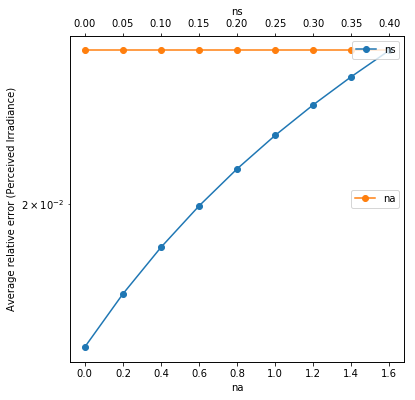

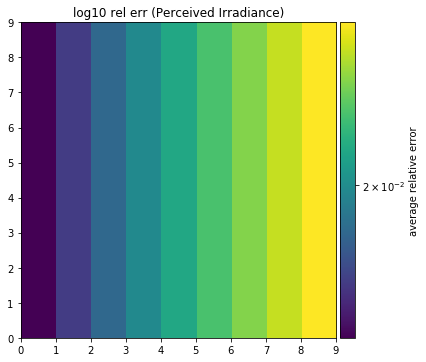

In [113]:
num_scatters = 4
plot_asymptotics_study_fixed_num_scatters(abs_err_dict, rel_err_dict, num_scatters)

## Compare FD radiance to no-scatter asymptotics radiance

In [203]:
import ipywidgets as ipw
import pandas as pd
import IPython.display as disp

In [328]:
def plot_irrad_column(irrad1, irrad2, label1, label2, i, j, plot_data, plot_err, log_data, log_err):
    col1 = irrad1[i,j,:]
    col2 = irrad2[i,j,:]
    abs_err = np.abs(col1 - col2)
    rel_err = np.abs(abs_err / col1)
    
    # Plot
    if(plot_data):
        data_ax = plt.gca()
        data_ax.plot(col1, 'C0o-', label=label1)
        data_ax.plot(col2, 'C1o-', label=label2)
        plt.legend(loc='upper right')
        if(log_data):
            data_ax.set_yscale('log')

    if(plot_err):
        err_ax = plt.twinx()
        err_ax.plot(abs_err, 'C2o-', label='abs_err')
        err_ax.plot(rel_err, 'C3o-', label='rel_err')
        plt.legend(loc='right')
        if(log_err):
            err_ax.set_yscale('log')
    plt.show()
    
    # DataFrame
    df = pd.DataFrame(
        list(zip(
            *map(
                lambda arr: ['{:10.3e}'.format(x) for x in arr],
                (col1, col2, abs_err, rel_err)
            )
        )),
        columns=('Finite Difference', 'No Scattering', 'Absolute Error', 'Relative Error')
    )
    disp.display(df)
    
    

In [332]:
def plot_rad_column(rad1, rad2, label1, label2, i, j, p, plot_data, plot_err, log_data, log_err):
    col1 = rad1[i,j,:, p]
    col2 = rad2[i,j,:, p]
    abs_err = np.abs(col1 - col2)
    rel_err = np.abs(abs_err / col1)
    
    # Plot
    plt.figure(1)
    if(plot_data):
        data_ax = plt.gca()
        data_ax.plot(col1, 'C0o-', label=label1)
        data_ax.plot(col2, 'C1o-', label=label2)
        plt.legend(loc='upper right')
        if(log_data):
            data_ax.set_yscale('log')

    if(plot_err):
        err_ax = plt.twinx()
        err_ax.plot(abs_err, 'C2o-', label='abs_err')
        err_ax.plot(rel_err, 'C3o-', label='rel_err')
        plt.legend(loc='right')
        if(log_err):
            err_ax.set_yscale('log')
    plt.show()
    
    # DataFrame
    df = pd.DataFrame(
        list(zip(
            *map(
                lambda arr: ['{:10.3e}'.format(x) for x in arr],
                (col1, col2, abs_err, rel_err)
            )
        )),
        columns=('Finite Difference', 'No Scattering', 'Absolute Error', 'Relative Error')
    )
    disp.display(df)
    
    

### Load Data

In [383]:
study_name = 'as_single_large'
a_water = 0.5
b = 0.5

nz = cori_nc_get_results(
    study_name, 'nz',
    fd_flag=True,
    a_water=a_water, b=b
)[0][0]
zmin = 0
zmax = cori_nc_get_results(
    study_name, 'zmax',
    fd_flag=True,
    a_water=a_water, b=b
)[0][0]

dz = (zmax - zmin) / nz
z = dz * (np.arange(nz) + 0.5)

fd_rad = cori_nc_get_results(
    study_name, 'rad',
    fd_flag=True,
    a_water=a_water, b=b
)[0][0]
no_scat_rad = cori_nc_get_results(
    study_name, 'rad',
    fd_flag=False, num_scatters=0,
    a_water=a_water, b=b
)[0][0]

fd_irrad = cori_nc_get_results(
    study_name, 'irrad',
    fd_flag=True,
    a_water=a_water, b=b
)[0][0]
no_scat_irrad = cori_nc_get_results(
    study_name, 'irrad',
    fd_flag=False, num_scatters=0,
    a_water=a_water, b=b
)[0][0]

fd_p_kelp = cori_nc_get_results(
    study_name, 'p_kelp',
    fd_flag=True,
    a_water=a_water, b=b
)[0][0]
no_scat_p_kelp = cori_nc_get_results(
    study_name, 'p_kelp',
    fd_flag=False, num_scatters=0,
    a_water=a_water, b=b
)[0][0]

In [384]:
# Irrad
ipw.interact(
    plot_irrad_column,
    irrad1=ipw.fixed(fd_irrad),
    irrad2=ipw.fixed(no_scat_irrad),
    label1=ipw.fixed('FD'),
    label2=ipw.fixed('NoScat'),
    i=(0,15), j=(0,15),
    plot_data=True, plot_err=False,
    log_data=True, log_err=True
)

interactive(children=(IntSlider(value=7, description='i', max=15), IntSlider(value=7, description='j', max=15)…

<function __main__.plot_irrad_column(irrad1, irrad2, label1, label2, i, j, plot_data, plot_err, log_data, log_err)>

In [375]:
# p_kelp
ipw.interact(
    plot_irrad_column,
    irrad1=ipw.fixed(fd_p_kelp),
    irrad2=ipw.fixed(no_scat_p_kelp),
    label1=ipw.fixed('FD'),
    label2=ipw.fixed('NoScat'),
    i=(0,15), j=(0,15),
    plot_data=True, plot_err=False,
    log_data=True, log_err=True
)

interactive(children=(IntSlider(value=7, description='i', max=15), IntSlider(value=7, description='j', max=15)…

<function __main__.plot_irrad_column(irrad1, irrad2, label1, label2, i, j, plot_data, plot_err, log_data, log_err)>

## Compare radiances

In [385]:
# rad
ipw.interact(
    plot_rad_column,
    rad1=ipw.fixed(fd_rad),
    rad2=ipw.fixed(no_scat_rad),
    label1=ipw.fixed('FD'),
    label2=ipw.fixed('NoScat'),
    i=(0,15), j=(0,15), p=(0, 100),
    plot_data=True, plot_err=False,
    log_data=True, log_err=True
)
plt.figure(1)


interactive(children=(IntSlider(value=7, description='i', max=15), IntSlider(value=7, description='j', max=15)…

### Absorption coefficient for uniform kelp

In [372]:
absorptance_kelp = 0.8
num_dens = 150
ft = 4e-4
a_water = 0.5
a_final = a_water + num_dens * (absorptance_kelp + a_water*ft)
I0 = 50

In [346]:
a_final

120.53

In [347]:
absorptance_kelp / ft

2000.0

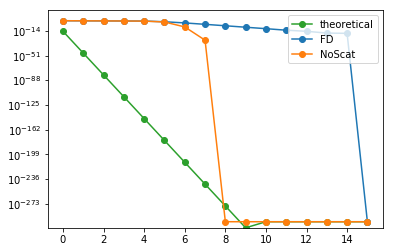

,Finite Difference,No Scattering,Absolute Error,Relative Error
0,1.693e+01,1.682e+01,1.090e-01,6.439e-03
1,1.232e+01,1.226e+01,5.971e-02,4.847e-03
2,9.228e+00,8.969e+00,2.599e-01,2.816e-02
3,6.549e+00,6.536e+00,1.339e-02,2.044e-03
4,5.035e+00,4.118e+00,9.164e-01,1.820e-01
5,4.719e-01,2.124e-01,2.595e-01,5.499e-01
6,8.200e-03,8.370e-09,8.200e-03,1.000e+00
7,6.545e-05,1.186e-28,6.545e-05,1.000e+00
8,4.473e-07,0.000e+00,4.473e-07,1.000e+00
9,2.957e-09,0.000e+00,2.957e-09,1.000e+00


In [351]:
plt.semilogy(I0*np.exp(-a_final*z), 'C2o-', label='theoretical')
#plt.ylim(1e-50,1e1)
plot_rad_column(
    rad1=fd_rad,
    rad2=no_scat_rad,
    label1='FD',
    label2='NoScat',
    i=7, j=7, p=0,
    plot_data=True, plot_err=False,
    log_data=True, log_err=True
)
plt.show()

In [312]:
a_final

120.53